In [5]:
import mne
import scipy
import numpy as np
import matplotlib.pyplot as plt
import utils
from scipy.stats import zscore, pearsonr
%matplotlib widget

### Data preparation

**EEG signals:** Load EEGLAB datasets -> Re-reference -> Highpass filter -> downsample

**Features of the video:** Extracted with Dmochowski's code (https://github.com/dmochow/SRC)

In [6]:
# Load video features
features_data = scipy.io.loadmat('../Correlated Component Analysis/data/features.mat')
fsStim = int(features_data['fsVideo']) # fs of the video 
features = np.nan_to_num(features_data['muFlow']) # feature: optical flow

In [9]:
# Load EEGLAB dataset and revise dataset info
eeglab_set = '../../Experiments/data/AS/Videos/Parra.set'
raw_lab = mne.io.read_raw_eeglab(eeglab_set, preload=True)
fsEEG = raw_lab.info['sfreq']
raw_lab.rename_channels({'B1': 'Fpz', 'B2': 'Fp2', 'B3': 'AF8', 'B4': 'AF4',
'B5': 'Afz', 'B6': 'Fz', 'B7': 'F2','B8': 'F4', 'B9': 'F6', 'B10': 'F8',
'B11': 'FT8', 'B12': 'FC6', 'B13': 'FC4', 'B14': 'FC2', 'B15': 'FCz', 'B16': 'Cz', 
'B17': 'C2', 'B18': 'C4', 'B19': 'C6', 'B20': 'T8', 'B21': 'TP8', 'B22': 'CP6',
'B23': 'CP4', 'B24': 'CP2', 'B25': 'P2', 'B26': 'P4', 'B27': 'P6', 'B28': 'P8', 
'B29': 'P10', 'B30': 'PO8', 'B31': 'PO4', 'B32': 'O2'})

Reading c:\Users\yyao\OneDrive - KU Leuven\KU Leuven\Codes\Canonical Correlation Analysis\..\..\Experiments\data\AS\Videos\Parra.fdt
Reading 0 ... 101129  =      0.000 ...   197.518 secs...


C:\Users\yyao\AppData\Local\Temp\ipykernel_14864\1375530870.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_lab = mne.io.read_raw_eeglab(eeglab_set, preload=True)
C:\Users\yyao\AppData\Local\Temp\ipykernel_14864\1375530870.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_lab = mne.io.read_raw_eeglab(eeglab_set, preload=True)


<RawEEGLAB | Parra.fdt, 64 x 101130 (197.5 s), ~49.5 MB, data loaded>

In [10]:
# Data visualization (not re-referenced)
# It allows visual inspection and to manually select bad channels or data spans
# Skip for now
# raw_lab.plot(n_channels=64, scalings='auto')
# raw_lab.compute_psd().plot(average=True)

In [11]:
# Re-reference
raw_lab.set_eeg_reference(ref_channels=['Cz']) # Select the reference channel to be Cz
# TODO: Is removing dc offset necessary after re-referencing?
# Highpass filter - remove slow drifts
HP_cutoff = 0.5
raw_highpass = raw_lab.copy().filter(l_freq=HP_cutoff, h_freq=None)
# raw_highpass.compute_psd().plot(average=True)
# Remove power line noise
AC_freqs = 50 # AC power line frequency
row_notch = raw_highpass.copy().notch_filter(freqs=AC_freqs)
# row_notch.compute_psd().plot(average=True)
# Resampling
raw_downsampled = row_notch.copy().resample(sfreq=fsStim)
# raw_downsampled.compute_psd().plot(average=True)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequ

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


In [12]:
# Load eeg data and sample rate
eeg_channel_indices = mne.pick_types(raw_lab.info, eeg=True)
eeg_downsampled, times = raw_downsampled[eeg_channel_indices]
eeg_downsampled = eeg_downsampled[:,:len(features)].T
times = times[:len(features)]
normalized_features = zscore(features) # normalize features

### CCA

Run canonical component analysis

In [13]:
L_timefilter = fsStim
n_components = 5
# Find the convolution matrix and run CCA (with all data)
conv_mtx = utils.convolution_mtx(L_timefilter, normalized_features)
corr_coe, p_value, V_A, V_B = utils.cano_corr(eeg_downsampled, conv_mtx, n_components=n_components)
filtered_EEG = eeg_downsampled@V_A
filtered_Sti = conv_mtx@V_B
print('Note: no unseen data')
print('Correlation coefficients of the top {} components: {}'.format(n_components, corr_coe))
print('P-values of the top {} components: {}'.format(n_components, p_value))

Note: no unseen data
Correlation coefficients of the top 5 components: [0.32859373 0.30429471 0.20496938 0.16069826 0.15049291]
P-values of the top 5 components: [5.19468314e-149 5.09762255e-127 3.67323701e-057 1.57313692e-035
 2.54684903e-031]


In [14]:
# Cross validation
fold = 10
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
for idx in range(fold):
    EEG_train, EEG_test, Sti_train, Sti_test = utils.split(eeg_downsampled, normalized_features, fold=fold, fold_idx=idx+1)
    conv_mtx_train = utils.convolution_mtx(L_timefilter, Sti_train)
    corr_train[idx,:], p_value_train, V_A_train, V_B_train = utils.cano_corr(EEG_train, conv_mtx_train, n_components=n_components)
    conv_mtx_test = utils.convolution_mtx(L_timefilter, Sti_test)
    corr_test[idx,:], p_value_test, _, _ = utils.cano_corr(EEG_test, conv_mtx_test, n_components=n_components, V_A=V_A_train, V_B=V_B_train)
print('Average correlation coefficients of the top {} components on the training sets: {}'.format(n_components, np.average(corr_train, axis=0)))
print('Average correlation coefficients of the top {} components on the test sets: {}'.format(n_components, np.average(corr_test, axis=0)))

Average correlation coefficients of the top 5 components on the training sets: [0.34050319 0.31518509 0.2142627  0.16899192 0.15576927]
Average correlation coefficients of the top 5 components on the test sets: [0.10675249 0.07818269 0.01776574 0.02271515 0.05501742]


In [16]:
dt = times[1]-times[0]
grad = np.gradient(np.squeeze(features), dt)
grad_2 = np.gradient(grad, dt)
grad_3 = np.gradient(grad_2, dt)

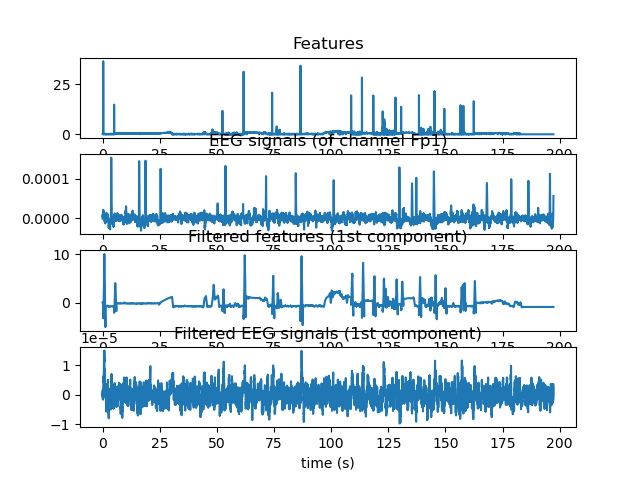

In [15]:
# Visualizations of component 1
plt.close()
compo = 1
ax1 = plt.subplot(411)
ax1.plot(times, features)
ax1.title.set_text('Features')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, eeg_downsampled[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (1st component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (1st component)')
ax4.set_xlabel('time (s)')
plt.show()

In [17]:
V_B[:,compo-1]

array([-0.10877076, -0.08105104, -0.06953025, -0.08269197, -0.02779456,
       -0.00352794,  0.03550194,  0.1018806 ,  0.12098332,  0.12461918,
        0.22016099,  0.22291504,  0.28125511,  0.33191648,  0.31982411,
        0.3693596 ,  0.32247958,  0.26707672,  0.24387361,  0.1980774 ,
        0.18375044,  0.16060524,  0.0964216 , -0.0184364 , -0.04377753,
       -0.06411663, -0.07302623, -0.07341831, -0.14162025, -0.14543806])

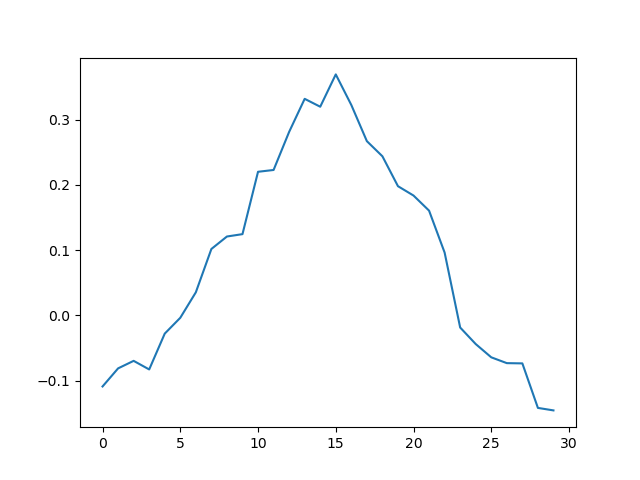

In [18]:
plt.close()
plt.plot(range(len(V_B[:,compo-1])), V_B[:,compo-1])
plt.show()

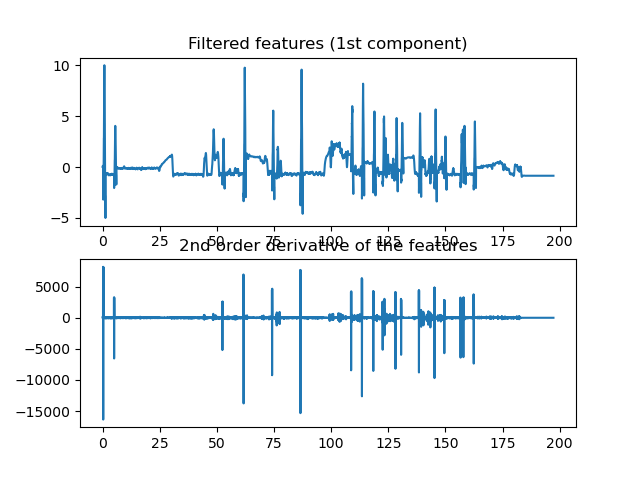

In [20]:
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (1st component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad_2)
ax2.title.set_text('2nd order derivative of the features')
plt.show()

- Filtered vs single channel EEG: The eye blink artifacts have been suppressed
- Filtered vs unfiltered features: Shapes are similar; Filtered features are smoother (triangle filter)
- Filtered features and filtered EEG: Peaks are aligned

Note: peaks in features occur when there are scene shifts

In [ ]:
# Visualizations of component 2
plt.close()
compo = 2
ax1 = plt.subplot(411)
ax1.plot(times, features)
ax1.title.set_text('Features')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, eeg_downsampled[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (2nd component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (2nd component)')
ax4.set_xlabel('time (s)')
plt.show()

In [ ]:
V_B[:,compo-1]

In [ ]:
plt.close()
plt.plot(range(len(V_B[:,compo-1])), V_B[:,compo-1])
plt.show()

- Filtered vs single channel EEG: The eye blink artifacts have been suppressed; Peaks are not easily distinguishable
- Filtered vs unfiltered features: Filtered features capture the 1st order information of the original features
- Filtered features and filtered EEG: The alignment of the peaks is not very significant

In [ ]:
plt.close()
compo = 2
ax1 = plt.subplot(311)
ax1.plot(times, features)
ax1.title.set_text('Features')
ax2 = plt.subplot(312, sharex = ax1)
ax2.plot(times, filtered_Sti[:,compo-1])
ax2.title.set_text('Filtered features (2nd component)')
ax3 = plt.subplot(313, sharex = ax1)
ax3.plot(times, grad)
ax3.title.set_text('Gradients of the features')
plt.show()

In [ ]:
grad_grad = np.gradient(grad, dt)

In [ ]:
compo = 3
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (3rd component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad_grad)
ax2.title.set_text('2nd order derivative of the features')
plt.show()

In [ ]:
V_B[:,compo-1]

In [ ]:
plt.close()
plt.plot(range(len(V_B[:,compo-1])), V_B[:,compo-1])
plt.show()

In [ ]:
grad_3 = np.gradient(grad_grad, dt)

In [ ]:
compo = 4
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (4th component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad_3)
ax2.title.set_text('3rd order derivative of the features')
plt.show()

In [ ]:
V_B[:,compo-1]

In [ ]:
plt.close()
plt.plot(range(len(V_B[:,compo-1])), V_B[:,compo-1])
plt.show()